# Банки — Сегментация пользователей по потреблению

**Описание проекта:** необходимо провести сегментацию клиентов банка в разрезе числа использованных продуктов для менеджера продукта.

**Цель:** снизить отток путем сегментации клиентов и предложением им релевантных продуктов

**Задачи:** 
1. Провести первичный анализ данных и предобработку
2. Провести исследовательский анализ данных
3. Определить существенные признаки, влияющие на кол-во продуктов и отток
4. Сегментировать пользователей по кол-ву продуктов и оттоку
5. Протестировать гипотезы

**Описание данных:**

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Equity` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

## Первичный обзор данных
    Проведем первичный анализ данных: импортируем библиотеки, посмотрим общую информацию о датасете.

### Загрузка библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import warnings as wr #убираем предупреждение об ошибках
wr.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)
pd.set_option("display.float_format", "{:.2f}".format)

### Просмотр общей информации о датасете

In [2]:
try:
    df = pd.read_csv('bank_scrooge.csv')
except:
    df = pd.read_csv('https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F') #загружаем датасет

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [4]:
df.describe(include='all')

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.00,10000.00,10000,10000,9974.00,10000.00,7705.00,10000.00,10000.00,10000.00,10000.00,10000.00
unique,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Ярославль,М,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,5888,5005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,171814.71,848.70,NaN,NaN,42.73,2.63,827794.31,1.87,0.68,0.52,147866.89,0.18
std,33708.24,65.45,NaN,NaN,12.18,1.98,1980614.15,0.79,0.47,0.50,139388.51,0.39
min,94561.00,642.00,NaN,NaN,18.00,0.00,0.00,0.00,0.00,0.00,2546.30,0.00
25%,142810.25,802.00,NaN,NaN,33.00,0.00,295554.16,1.00,0.00,0.00,75251.90,0.00
50%,172728.00,853.00,NaN,NaN,40.00,3.00,524272.20,2.00,1.00,1.00,119658.10,0.00
75%,201261.75,900.00,NaN,NaN,51.00,4.00,980705.85,2.00,1.00,1.00,174500.54,0.00


Датасет имеет 10 000 строк, 12 столбцов. На первый взгляд имеется небольшое кол-во пропусков, необходимо изменить названия столбцов на змеиный регистр. 
Возраст распределен от 18 до 86 - правдоподобно, выбросов нет. Непонятные значения в столбцах `balance` и `EST_SALARY`.

## Предобработка данных
В данном разделе изменим названия столбцов, обработаем пропуски, дубликаты и аномалии.

### Смена названий столбцов
Необходимо привести названия столбцов в змеиный регистр. Всего таких столбцов два: 'USERID' и 'EST_SALARY'.

In [5]:
df = df.rename(columns={'USERID': 'user_id', 'EST_SALARY': 'salary'})
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn
0,183012,850.00,Рыбинск,Ж,25.00,1,59214.82,2,0,1,75719.14,1
1,146556,861.00,Рыбинск,Ж,37.00,5,850594.33,3,1,0,86621.77,0
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,107683.34,0
3,225363,866.00,Ярославль,Ж,51.00,5,1524746.26,2,0,1,174423.53,1
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,67353.16,1


### Типы данных

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  salary         10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Необходимо поменять тип данных столбца `age`.

In [7]:
df['age'] = df['age'].astype('Int64')
df['age'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 10000 entries, 0 to 9999
Series name: age
Non-Null Count  Dtype
--------------  -----
9974 non-null   Int64
dtypes: Int64(1)
memory usage: 88.0 KB


Тип данных успешно изменен.

### Анализ и обработка пропусков
Необходимо проанализировать природу пропусков и обработать их.

In [8]:
pd.DataFrame(round(df.isna().mean()*100,1)).style.background_gradient('Reds') #пропуски в столбцах в %

,0
user_id,0.000000
score,0.000000
city,0.000000
gender,0.000000
age,0.300000
equity,0.000000
balance,23.000000
products,0.000000
credit_card,0.000000
last_activity,0.000000


По тепловой карте пропусков видно, что 23% пропусков в столбце с балансом. И всего 0,3% пропусков в столбце с возрастом.

In [9]:
df.isna().sum() #число пропусков

user_id             0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
salary              0
churn               0
dtype: int64

Можно предположить, что пропущенные значения в столбце с балансом - нулевой баланс. Можно было бы заменить эти значения на нули, но так как данные выгружены на определенный момент, то заполнение нулями может повлиять на исследование распределения в целом по балансу. Заменять чем-либо другим ропуски - так же некорретно, пока не выявлена природа пропусков.

<AxesSubplot:>

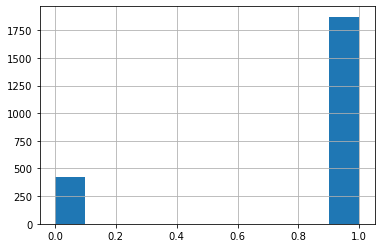

In [10]:
df[(df['balance'].isna())]['credit_card'].hist()

Больше всего пропусков у клиентов с кредитной картой. Возможно, на основной карте, баланс которой отображается в столбце "баланс", баланс нулевой, а все денежные средства находятся на кредитной карте.

<AxesSubplot:>

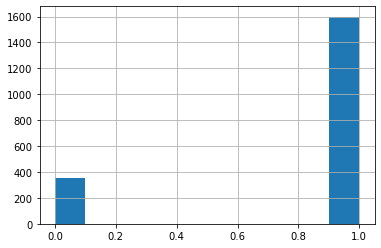

In [11]:
df[(df['balance'].isna()) & (df['products'] == 1)]['credit_card'].hist()

<AxesSubplot:>

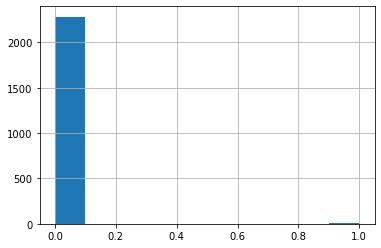

In [12]:
df[(df['balance'].isna()) ]['churn'].hist()

Клиентов, имеющих пропуск в балансе и имеющих всего 1 продукт - кредитную карту, 1600 человек. 

Также рассмотрим пропуски в разрезе города.

<AxesSubplot:>

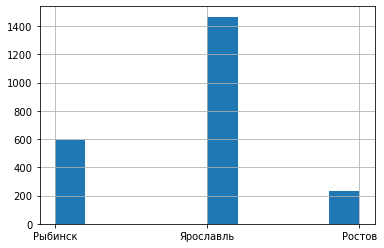

In [13]:
df[(df['balance'].isna()) ]['city'].hist()

Меньше всего пропусков в Ростове, но они так же есть.

Клиенты, имеющие пропуск в балансе, в подавляющем большинстве все еще клиенты банка. Значит нельзя утверждать, что система сбора данных работает так, что если клиент ушел, его баланс становится пропущенным значением.

Таким образом, природа пропусков не выявлена. Заменять значения или удалять нельзя.

### Анализ и обработка дубликатов
Необходимо рассмотреть явные и неявные дубликаты и обработать их.

In [14]:
print('Явных дубликатов: ',df.duplicated().sum())

Явных дубликатов:  0


In [15]:
print('Дубликатов по ID: ', df['user_id'].duplicated().sum())

Дубликатов по ID:  73


In [16]:
print('Дубликатов по ID и городу: ', df[['user_id', 'city']].duplicated().sum())

Дубликатов по ID и городу:  0


In [17]:
print('Дубликатов по ID и возрасту: ', df[['user_id', 'age']].duplicated().sum())

Дубликатов по ID и возрасту:  5


In [18]:
print('Дубликатов по ID и статусу ушедшего: ', df[['user_id', 'churn']].duplicated().sum())

Дубликатов по ID и статусу ушедшего:  23


Обнаружено 0 явных дубликатов (полных), 73 дубликатов по ID. Так как ID клиентов будут использоваться в исследовании как количество клиентов, можно применить метод reset_index() для сброса индексов и присваивания новых.

In [19]:
df = df.reset_index()
df = df.drop('user_id', axis=1)
df = df.rename(columns={'index': 'user_id'})
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn
0,0,850.00,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,1,861.00,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,2,892.00,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
3,3,866.00,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,4,730.00,Ярославль,М,34,5,174.00,1,1,0,67353.16,1


In [20]:
print('Дубликатов по ID: ', df['user_id'].duplicated().sum())

Дубликатов по ID:  0


Рассмотрим столбцы `city`, `gender` для выявления неявных дубликатов.

In [21]:
df['city'].unique()

array(['Рыбинск', 'Ярославль', 'Ростов'], dtype=object)

In [22]:
df['gender'].unique()

array(['Ж', 'М'], dtype=object)

Неявных дубликатов в этих столбцах нет.

Так как ID клиентов были сброшены, то все дубликаты, связанные с эти столбцом, исчезли.

Дубликаты обработаны.

### Анализ и обработка выбросов
Необходимо выявить и обработать аномальные выбивающиеся значения.

In [23]:
df.describe()

,user_id,score,age,equity,balance,products,credit_card,last_activity,salary,churn
count,10000.00,10000.00,9974.00,10000.00,7705.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,4999.50,848.70,42.73,2.63,827794.31,1.87,0.68,0.52,147866.89,0.18
std,2886.90,65.45,12.18,1.98,1980614.15,0.79,0.47,0.50,139388.51,0.39
min,0.00,642.00,18.00,0.00,0.00,0.00,0.00,0.00,2546.30,0.00
25%,2499.75,802.00,33.00,0.00,295554.16,1.00,0.00,0.00,75251.90,0.00
50%,4999.50,853.00,40.00,3.00,524272.20,2.00,1.00,1.00,119658.10,0.00
75%,7499.25,900.00,51.00,4.00,980705.85,2.00,1.00,1.00,174500.54,0.00
max,9999.00,1000.00,86.00,9.00,119113552.01,5.00,1.00,1.00,1395064.45,1.00


По таблице видно, что стандатртное отклонение в столбцах не так велико, в основном данные распределены нормально и соответствуют реальности.

Рассмотрим каждый количественный показатель на диаграмме для выявления выбросов.

Text(0.5, 1.0, 'Диаграммы размаха')

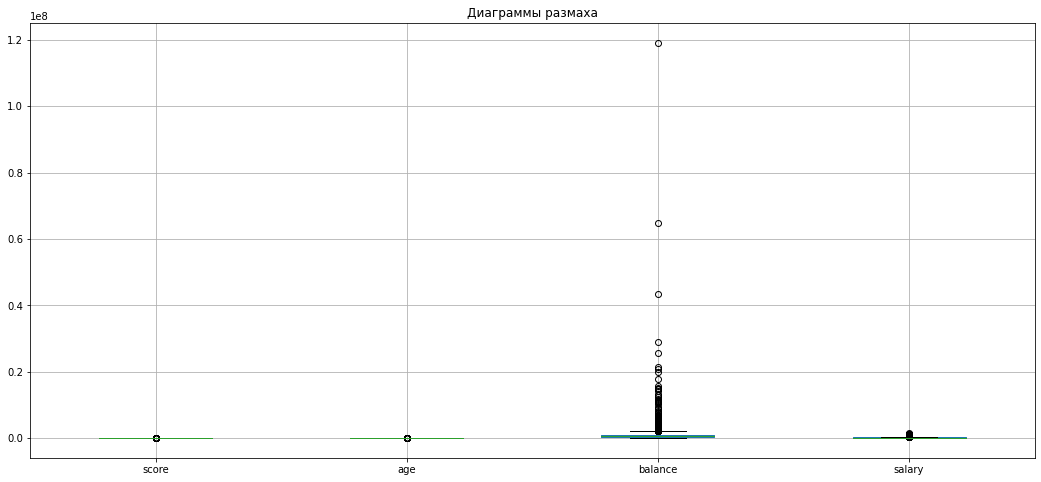

In [24]:
df[['score', 'age', 'balance', 'salary']].boxplot(figsize=(18,8))
plt.title('Диаграммы размаха')

Таким образом, наиболее выбивающиеся значения в столбце с балансом. Так как мы исследуем банк, скорее всего это не аномалии, а редкие случаи. Рассмотрим остальные столбцы ближе, без столбца баланса.

Text(0.5, 1.0, 'Диаграмма размаха')

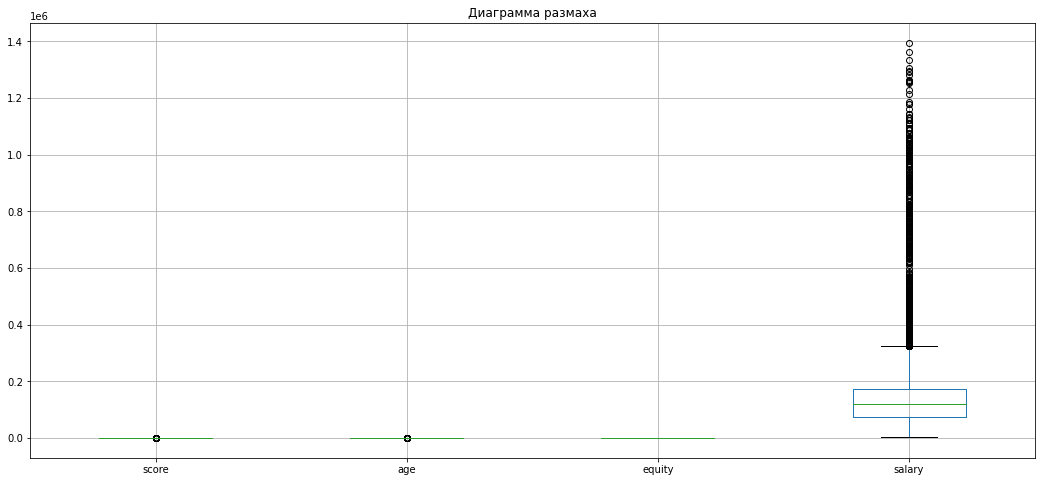

In [25]:
df[['score', 'age', 'equity', 'salary']].boxplot(figsize=(18,8))
plt.title('Диаграмма размаха')

Для солбца с оцененной заработной платой такая же логика, как и для баланса - вполне себе заработная плата может быть такой большой.

Text(0.5, 1.0, 'Диаграмма размаха по скорингу, возрасту, недвижимости')

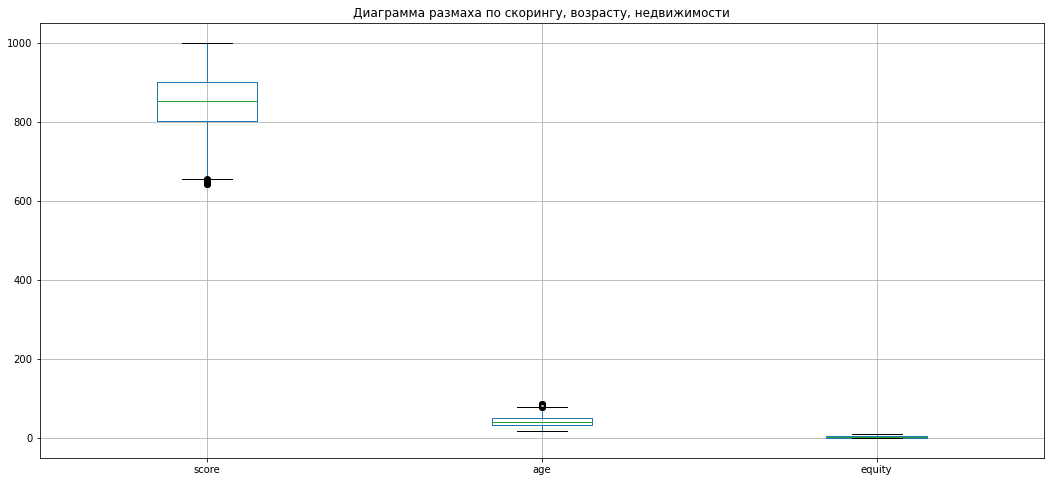

In [26]:
df[['score', 'age', 'equity']].boxplot(figsize=(18,8))
plt.title('Диаграмма размаха по скорингу, возрасту, недвижимости')

В остальных столбцах выбросы минимальны, либо их вообще нет.

Рассмотрим отдельно столбец `products`.

In [27]:
df['products'].describe()

count   10000.00
mean        1.87
std         0.79
min         0.00
25%         1.00
50%         2.00
75%         2.00
max         5.00
Name: products, dtype: float64

Минимальное значение - 0. Если человек является клиентом банка, он должен пользоваться хотя бы 1 продуктом. Посмотрим, что это за клиент.

In [28]:
df[df['products']==0]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn
8957,8957,962.00,Рыбинск,Ж,79,3,NaN,0,0,0,25063.96,1


Такой клиент всего 1, и он ушел из банка. Получается, что на момент ухода клиент не был активен в течение месяца, не имел продуктов и баланса, а еще он пенсионер. Такого клиента можно удалить из датасета.

In [29]:
df = df[df['products']!=0]
df['products'].describe()

count   9999.00
mean       1.87
std        0.79
min        1.00
25%        1.00
50%        2.00
75%        2.00
max        5.00
Name: products, dtype: float64

**Промежуточный вывод:** датасет имеет 10 000 наблюдений, 12 колонок. Имел небольшое количество пропусков в столбце с балансом, которые могут быть нулевым балансом. Также были обработаны 73 дубликата `user_id`, после сброса которых все парные дубликаты исчезли. Выбросы имеют под собой основание.

## Исследовательский анализ данных
Необходимо визуализировать распределения признаков, построить матрицу корреляции. Составить предварительные выводы.
    
   

### Визуализация распределения признаков

Построим диаграммы по каждому признаку.

Для баллов скоринга:

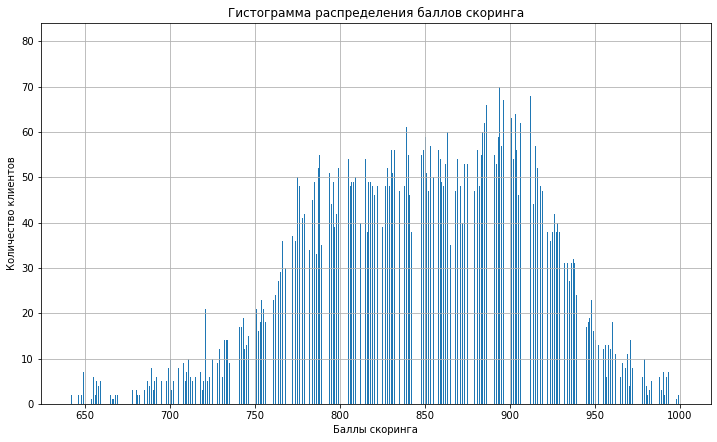

In [30]:
df['score'].hist(figsize=(12, 7), bins=1000)
plt.ylabel('Количество клиентов')
plt.xlabel('Баллы скоринга')
plt.title('Гистограмма распределения баллов скоринга')
plt.show()

Баллы скоринга распределены равномерно без выбросов. В основном у клиентов от 775 до 925 баллов.

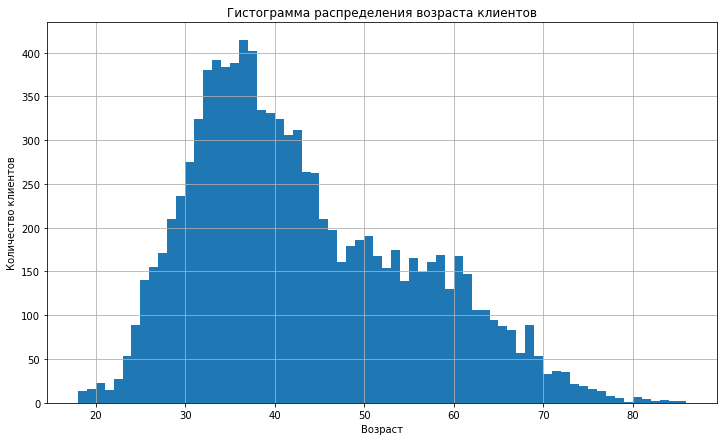

In [31]:
df['age'].hist(figsize=(12, 7), bins=(86-18))
plt.ylabel('Количество клиентов')
plt.xlabel('Возраст')
plt.title('Гистограмма распределения возраста клиентов')
plt.show()

Больше всего клиентов в возрасте от 25 до 55. Возраст так же распределен равномерно.

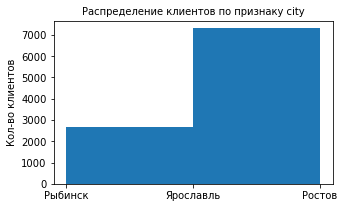

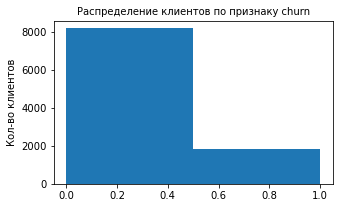

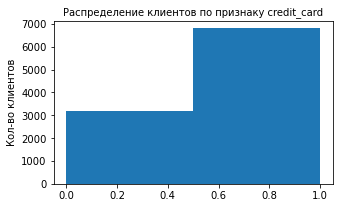

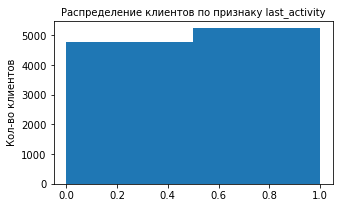

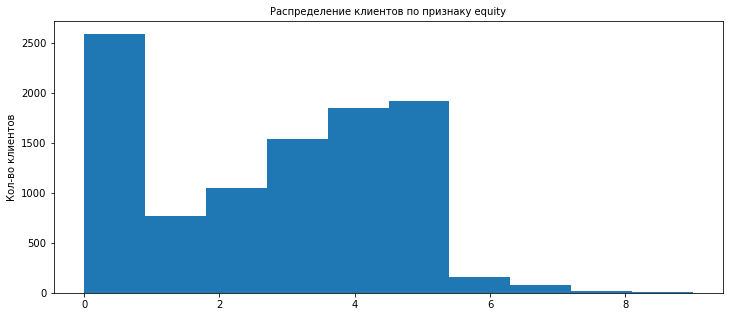

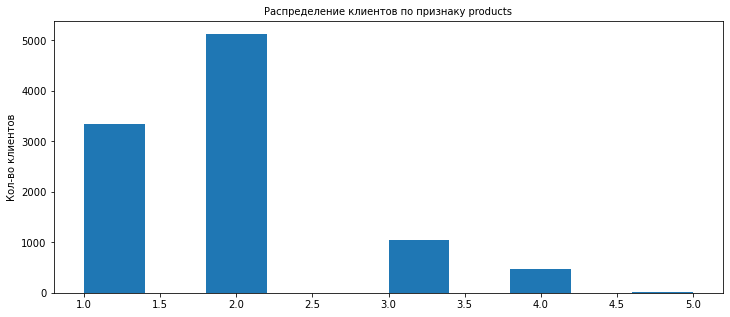

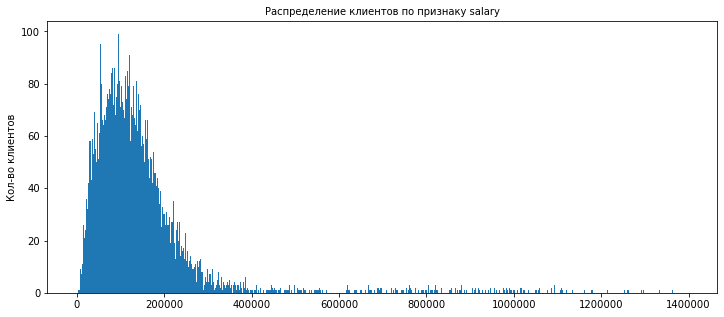

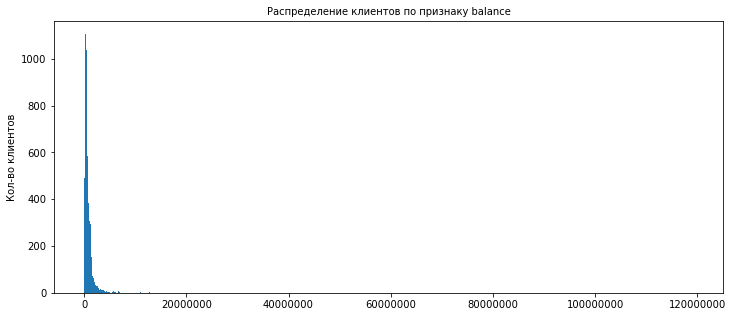

In [32]:
def gender_client(data):
    #fig, ax = plt.subplots(2, 4, figsize=[15,5])
    for col in ['city', 'churn', 'credit_card', 'last_activity']:
        
        plt.figure(figsize=(5,3))
        ax = plt.hist(data=data, bins=2, x=col)
        plt.ylabel('Кол-во клиентов')
        plt.title(f'Распределение клиентов по признаку {col}', size=10)
        plt.show()
        
    for col in ['equity', 'products']:
        
        plt.figure(figsize=(12,5))
        ax = plt.hist(data=data, bins=10, x=col)
        plt.ylabel('Кол-во клиентов')
        plt.title(f'Распределение клиентов по признаку {col}', size=10)
        plt.show()
    
    for col in ['salary', 'balance']:
        
        plt.figure(figsize=(12,5))
        ax = plt.hist(data=data, bins=1000, x=col)
        plt.ylabel('Кол-во клиентов')
        plt.title(f'Распределение клиентов по признаку {col}', size=10)
        plt.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
        plt.show()

gender_client(df)

Больше всего баллов собственности в количестве 0 и 5.

В основном клиенты имеют по 2 продукта.

Клиенты с кредитной картой превышают клиентов без кредитной карты больше, чем в два раза.

Клиентов практически одинаковое количество.

Распределение заработной платы напоминает распределение Пуассона - что говорит о реальности данных. 

В основном в датасете отображены действительные клиенты. Лишь 1820 из них ушло.

Больше всего клиентов из Ярославля. В два раза меньше из Рыбинска и Ростова.

### Матрица корреляции признаков (тепловая карта)

Добавим в датасет кодирование. 

Добавим несколько новых столбцов: женский пол, мужской пол, города.

In [33]:
df['gender_2']=df['gender'] 
df['city_2']=df['city'] 

In [34]:
df = pd.get_dummies(df, columns = ['gender_2'])
df = pd.get_dummies(df, columns = ['city_2'])
df = df.rename (
    columns = ({
        'city_2_Ростов':'Ростов', 'city_2_Рыбинск':'Рыбинск','city_2_Ярославль':'Ярославль', 
        'gender_2_Ж':'female', 'gender_2_М':'male'}))

In [35]:
!pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [36]:
phik_overview = df[['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'salary', 'churn']].phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'salary', 'churn']


,score,age,equity,balance,products,credit_card,last_activity,salary,churn
score,1.00,0.04,0.53,0.17,0.42,0.21,0.05,0.40,0.23
age,0.04,1.00,0.04,0.02,0.14,0.16,0.09,0.36,0.18
equity,0.53,0.04,1.00,0.00,0.58,0.22,0.05,0.29,0.35
balance,0.17,0.02,0.00,1.00,0.00,0.00,0.00,0.37,0.02
products,0.42,0.14,0.58,0.00,1.00,0.27,0.11,0.22,0.26
credit_card,0.21,0.16,0.22,0.00,0.27,1.00,0.05,0.04,0.20
last_activity,0.05,0.09,0.05,0.00,0.11,0.05,1.00,0.05,0.26
salary,0.40,0.36,0.29,0.37,0.22,0.04,0.05,1.00,0.05
churn,0.23,0.18,0.35,0.02,0.26,0.20,0.26,0.05,1.00


In [37]:
interval_cols = ['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'salary', 'churn']
phik_overview = df.phik_matrix(interval_cols=interval_cols)

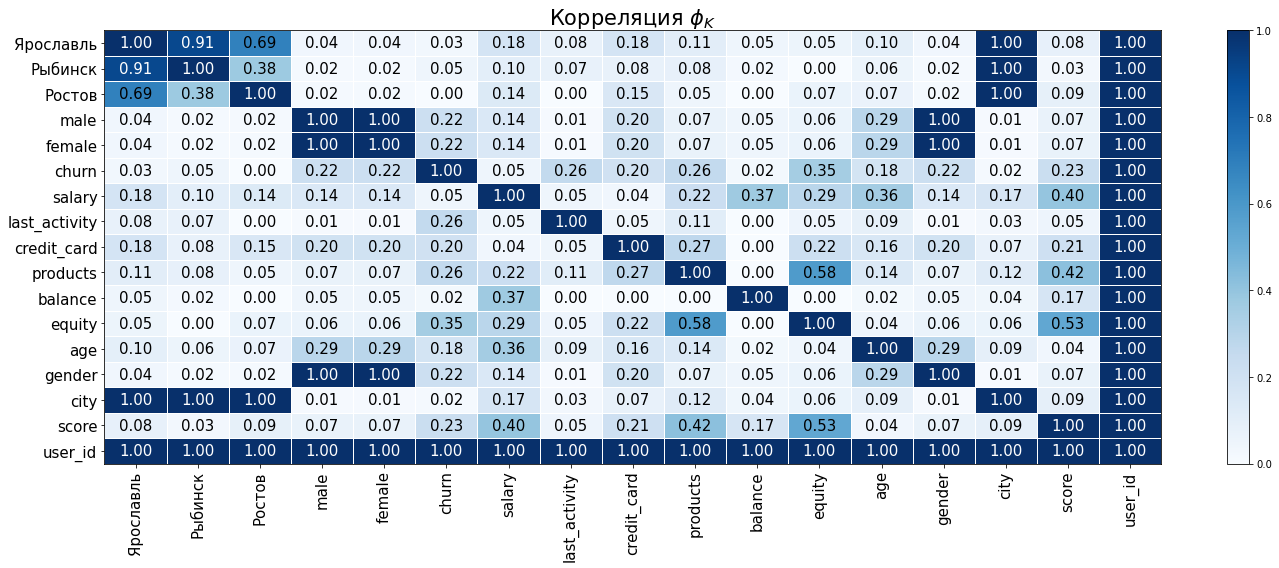

In [60]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 8))
plt.tight_layout()

Матрица корреляции построена по корреляции Фика. По матрице можно отследить параметры, влияющие друг на друга. Чем темнее ячейка, тем сильнее связь.

Выводы:
1. 0,58. Средняя положительная связь между баллами собственности и количеством продуктов: чем выше балл недвижимости, тем больше продуктов у клиента.
2. 0,53. Чем больше недвижимости, тем больше кредитный скоринг.
3. 0,42. Чем больше продуктов, тем больше кредитный скоринг. Это логично, на обслуживание продуктов нужны средства, значит они у клиента есть и его скоринг выше.
4. 0,4. Чем выше зарплата, тем больше скоринг.
5. 0,37. Чем больше зарплата, тем больше баланс.
6. 0,36. Чем старше клиент, тем больше зарплата. 
7. 0,35. Чем больше недвижимости, тем вероятнее уход.

На количество продуктов больше влияют: Недвижимость, Кредитный скоринг, Наличие кредитки.

На уход клиента больше влияют: Недвижимость, кол-во продуктов, последняя активность. 


### Предварительные выводы

Данные в датасете распределены нормально, похожи на реальные данные. Выбросов минимальное количество - скорее всего, это просто редкие значения. 

Клиенты банка в среднем от 25 до 55 лет, половина из них - из Ярославля, в основном имеют от 775 до 925 баллов скоринга, имеют от 0 до 5 баллов недвижимости, пользуются 1-2 продуктами, 70% имеют кредитную карту, 8000 из них действующие клиенты банка, 1820 ушло.

Больше всего на уход клиента влияют такие признаки, как количество продуктов и кол-во недвижимости.

## Сегментация по числу продуктов
### Определение основных признаков для сегментации
Необходимо определить, какие признаки больше влияют <br>
    а) в первую очередь на количество продуктов<br>
    б) во вторую очередь на отток
    
Рассмотрим визуализированную таблицу по возрасту пользователей для выделения сегментов.

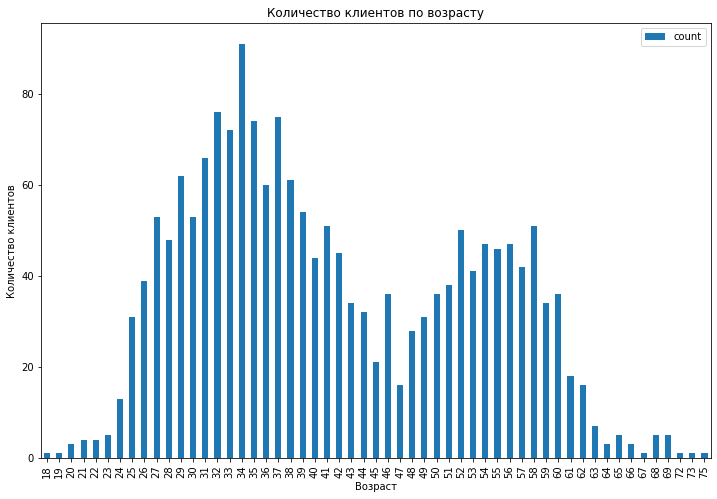

In [39]:
df[df['churn']==1]['age'].value_counts().reset_index().rename(columns={'index':'age', 
                                                                       'age':'count'}
                                                             ).sort_values(by='age').plot(kind='bar', 
                                                                                          figsize = (12,8), 
                                                                                          x = 'age', 
                                                                                          y = 'count', 
                                                                                          title='Количество клиентов по возрасту',
                                                                                         xlabel='Возраст',
                                                                                         ylabel='Количество клиентов')
plt.show()

По диаграмме можно выделить 4 сегмента:

1. от 18 до 25
2. от 26 до 45
3. от 46 до 62
4. от 63

Рассмотрим распределение клиентов по кол-ву продуктов в разрезе возраста. Для этого добавим категоризацию: каждого клиента отнесем к своей категории возраста.

In [40]:
def age_categorizer(age):
    try: 
        if 25 >= age >= 18:
            return '18-25'
        if 45 >= age > 25:
            return '26-45'
        if 62 >= age >= 46:
            return '46-62'
        if 63 <= age:
            return '63+' 
        else: return 'не определена'
    except: pass
    
df['age_category'] = df['age'].apply(age_categorizer)
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn,female,male,Ростов,Рыбинск,Ярославль,age_category
0,0,850.00,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,1,0,0,1,0,18-25
1,1,861.00,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,1,0,0,1,0,26-45
2,2,892.00,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,1,0,0,1,0,26-45
3,3,866.00,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,1,0,0,0,1,46-62
4,4,730.00,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,0,1,0,0,1,26-45


Закодируем полученный столбец и посмотрим влияние возрастной категории на количество продуктов.

In [41]:
df['age_category_2']=df['age_category']
df = pd.get_dummies(df, columns = ['age_category_2'])
df = df.rename (columns = ({
    'age_category_2_18-25':'18-25', 'age_category_2_26-45':'25-45','age_category_2_46-62':'46-62', 
    'age_category_2_63+':'63+'}))
display (df.head())

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,...,female,male,Ростов,Рыбинск,Ярославль,age_category,18-25,25-45,46-62,63+
0,0,850.00,Рыбинск,Ж,25,1,59214.82,2,0,1,...,1,0,0,1,0,18-25,1,0,0,0
1,1,861.00,Рыбинск,Ж,37,5,850594.33,3,1,0,...,1,0,0,1,0,26-45,0,1,0,0
2,2,892.00,Рыбинск,Ж,30,0,NaN,1,1,1,...,1,0,0,1,0,26-45,0,1,0,0
3,3,866.00,Ярославль,Ж,51,5,1524746.26,2,0,1,...,1,0,0,0,1,46-62,0,0,1,0
4,4,730.00,Ярославль,М,34,5,174.00,1,1,0,...,0,1,0,0,1,26-45,0,1,0,0


Рассмотрим на графике долю клиентов по возрастным группам.

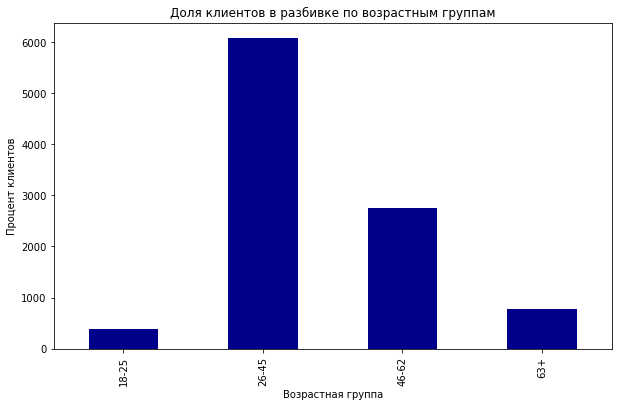

In [65]:
age_churn = df.pivot_table (index = 'age_category', values = 'user_id', aggfunc = 'count')

age_churn['user_id'].plot (
    kind='bar', title = 'Доля клиентов в разбивке по возрастным группам',
    xlabel = 'Возрастная группа', ylabel = 'Процент клиентов', figsize = (10,6), 
    color = 'darkblue')
plt.show()

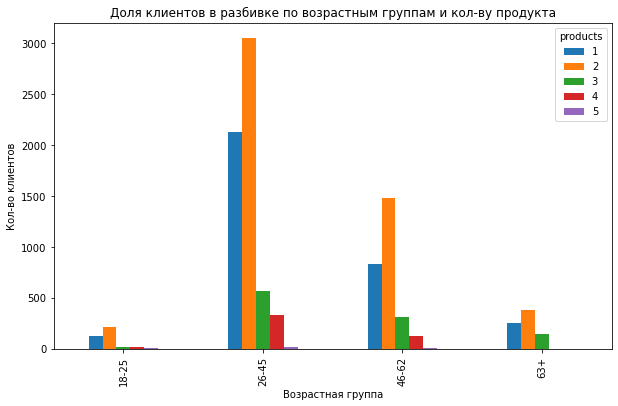

In [43]:
age_churn = df.pivot_table (index = 'age_category', columns = 'products', values='user_id', aggfunc ='count')

age_churn.plot (
    kind='bar', title = 'Доля клиентов в разбивке по возрастным группам и кол-ву продукта',
    xlabel = 'Возрастная группа', ylabel = 'Кол-во клиентов', figsize = (10,6))
plt.show()

На графике выделяется лидер по уходу - группа 46-62. Менее всего уходят группа 63+.

По продуктам: Больше всего пользуются продуктами 26-45. Чем больше возраст, тем меньше продуктов.

Оценим, насколько влияет наличие недвижимости на кол-во продуктов и отток.

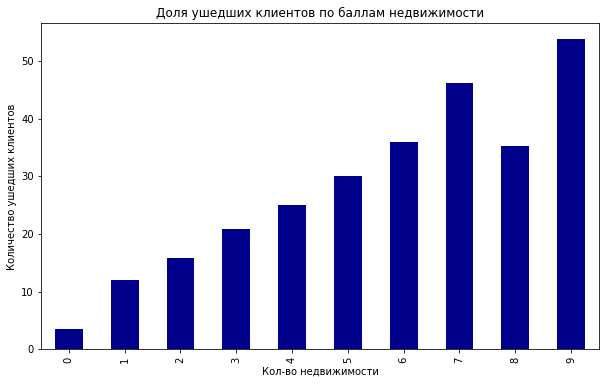

In [44]:
equity_churn = df.pivot_table (index = 'equity', values = 'churn', aggfunc = ['sum', 'count'])
equity_churn.columns = equity_churn.columns.droplevel(level=1)
equity_churn ['procent'] = equity_churn['sum']/equity_churn['count']*100

equity_churn['procent'].plot (
    kind='bar', title = 'Доля ушедших клиентов по баллам недвижимости',
    xlabel = 'Кол-во недвижимости', ylabel = 'Количество ушедших клиентов', figsize = (10,6), color = 'darkblue')
plt.show()

**Видна однозначная тенденция: чем больше недвижимости, тем больше вероятность ухода.**

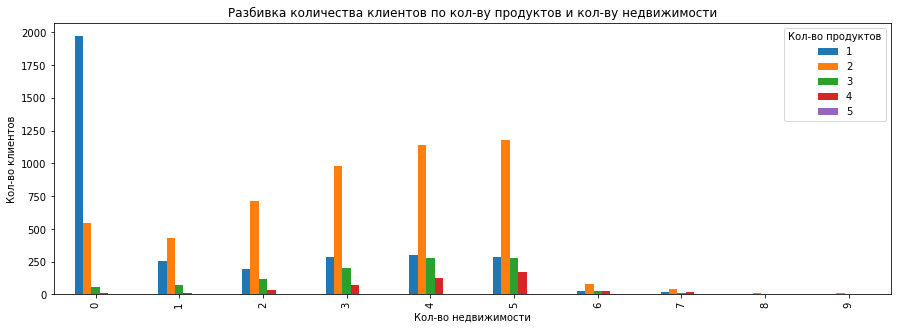

In [45]:
df.pivot_table(index='equity', columns='products', values='user_id', aggfunc='count').plot(kind='bar', figsize=(15,5))
plt.title('Разбивка количества клиентов по кол-ву продуктов и кол-ву недвижимости')
plt.xlabel('Кол-во недвижимости')
plt.ylabel('Кол-во клиентов')
plt.legend(title='Кол-во продуктов')
plt.show()

Видна тенденция: чем больше недвижимости, тем больше клиентов. Но только до кол-ва недвижимости до 6 баллов.

**Недвижимость однозначно можно включать в влияющие факторы.**

Рассмотрим влияние скорингового балла на кол-во продуктов и уход.

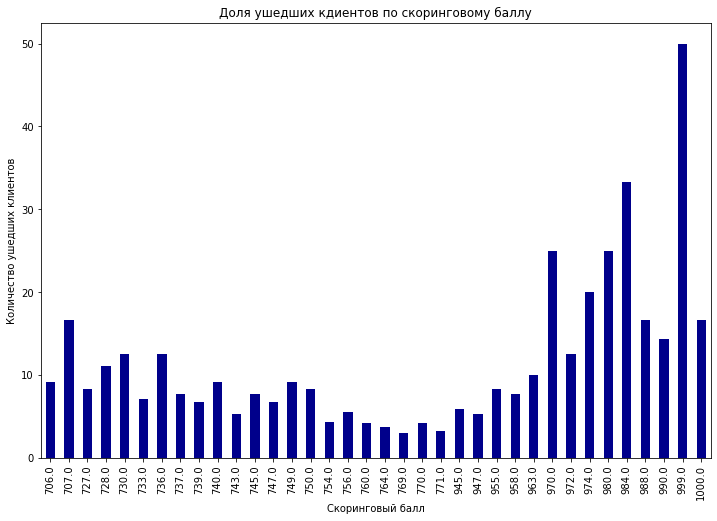

In [46]:
score_churn = df.pivot_table (index = 'score', values = 'churn', aggfunc =['sum', 'count'])
score_churn.columns = score_churn.columns.droplevel(level=1)
score_churn ['procent'] = score_churn['sum']/score_churn['count']*100
score_churn = score_churn [score_churn['sum']==1]

score_churn ['procent'].plot (
    kind = 'bar', figsize = (12,8), color = 'darkblue', 
    title = 'Доля ушедших кдиентов по скоринговому баллу', 
    xlabel = 'Скоринговый балл', 
    ylabel = 'Количество ушедших клиентов')
plt.show()

Наблюдается тенденция: уходили чаще клиенты с баллом выше 970. Совсем мало уходили клиенты с баллами от 707 до 947.

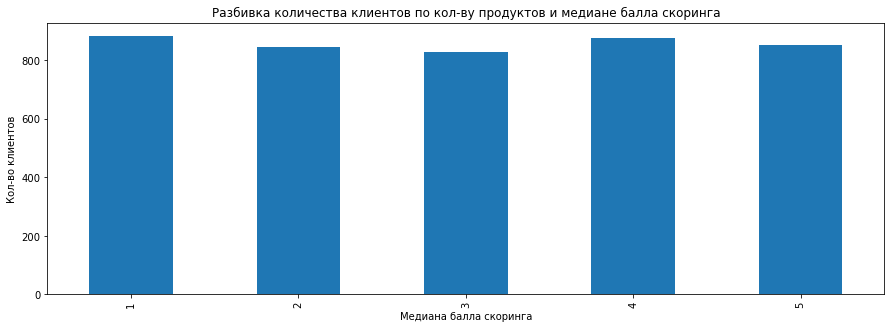

In [47]:
df.groupby('products')['score'].agg('median').plot(kind="bar", figsize=(15,5))
plt.title('Разбивка количества клиентов по кол-ву продуктов и медиане балла скоринга')
plt.xlabel('Медиана балла скоринга')
plt.ylabel('Кол-во клиентов')
plt.show()

Тенденций не наблюдается.

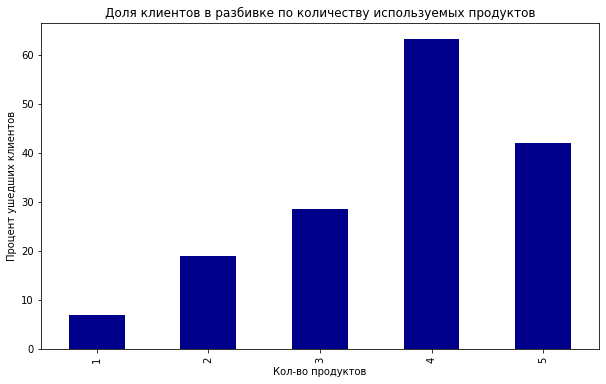

In [48]:
products_churn = df.pivot_table (index = 'products', values = 'churn', aggfunc = ['sum', 'count'])
products_churn.columns = products_churn.columns.droplevel(level=1)
products_churn ['perc'] = products_churn['sum']/products_churn['count']*100

# Построим столбчатую диаграмму:
products_churn['perc'].plot (
    kind='bar', title = 'Доля ушедших клиентов в разбивке по количеству используемых продуктов',
    xlabel = 'Кол-во продуктов', ylabel = 'Процент ушедших клиентов', figsize = (10,6), 
    color = 'darkblue')
plt.show()

Чаще всего уходят клиенты с 4 продуктами (больше 60%), 2-3 продукта примерно 20-30%.

Наличие кредитной карты:

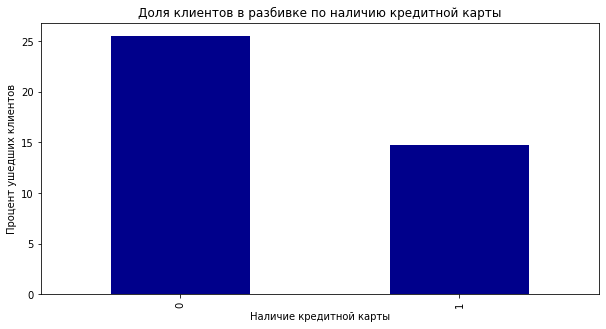

In [49]:
credit_card_churn = df.pivot_table (index = 'credit_card', values = 'churn', aggfunc = ['sum', 'count'])
credit_card_churn.columns = credit_card_churn.columns.droplevel(level=1)
credit_card_churn ['procent'] = credit_card_churn['sum']/credit_card_churn['count']*100

credit_card_churn['procent'].plot(
    kind='bar', figsize = (10,5), color = 'darkblue', xlabel = 'Наличие кредитной карты',
    title = 'Доля клиентов в разбивке по наличию кредитной карты',
    ylabel = 'Процент ушедших клиентов')
plt.show()

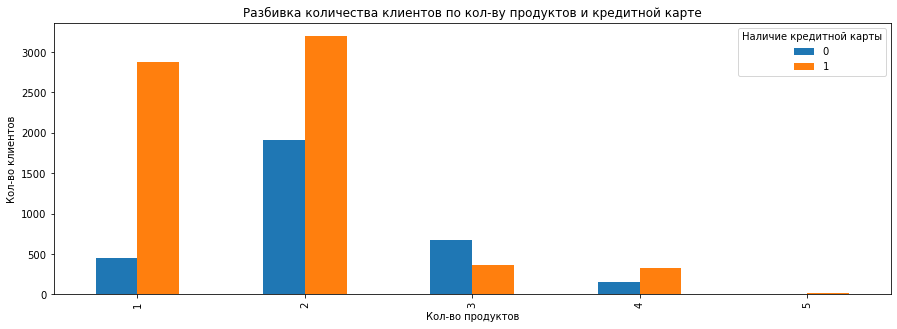

In [61]:
df.pivot_table (columns = 'credit_card', index = 'products', 
                values = 'user_id', aggfunc = 'count').plot(kind='bar', 
                                                                     figsize=(15,5))

plt.title('Разбивка количества клиентов по кол-ву продуктов и кредитной карте')
plt.xlabel('Кол-во продуктов')
plt.ylabel('Кол-во клиентов')
plt.legend(title='Наличие кредитной карты')
plt.show()

Чаще всего уходят клиенты без кредитной карты. Вероятно, наличие кредитной карты - весомый аргумент остаться в банке. 

У клиентов без кредитной картой чаще 2 продукта. Клиенты с картой чаще имеют по 1-2 продукта.

Рассмотрим активность за месяц:

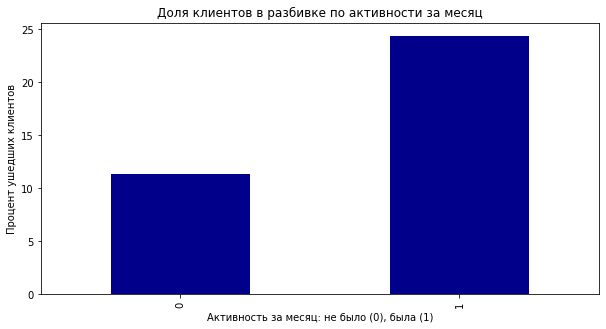

In [51]:
activity_churn = df.pivot_table (index = 'last_activity', values = 'churn', aggfunc = ['sum', 'count'])
activity_churn.columns = activity_churn.columns.droplevel(level=1)
activity_churn ['procent'] = activity_churn['sum']/activity_churn['count']*100

activity_churn['procent'].plot(
    kind='bar', title = 'Доля клиентов в разбивке по активности за месяц', figsize = (10,5), 
    color = 'darkblue', ylabel = 'Процент ушедших клиентов', xlabel = 'Активность за месяц: не было (0), была (1)')
plt.show()

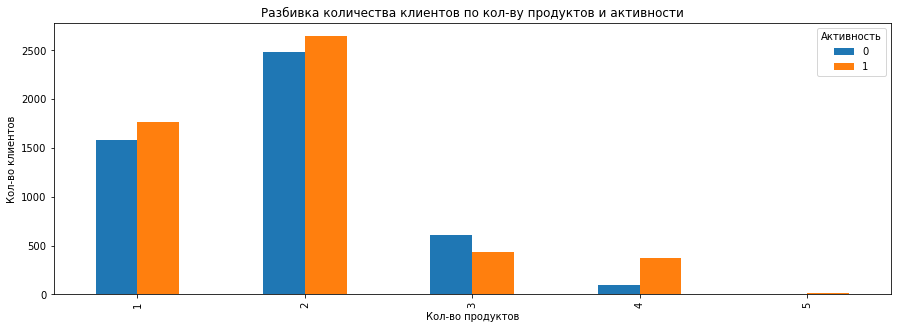

In [52]:
df.pivot_table (columns = 'last_activity', index = 'products', 
                values = 'user_id', aggfunc = 'count').plot(kind='bar', 
                                                                     figsize=(15,5))

plt.title('Разбивка количества клиентов по кол-ву продуктов и активности')
plt.xlabel('Кол-во продуктов')
plt.ylabel('Кол-во клиентов')
plt.legend(title='Активность')
plt.show()

Чаще уходят клиенты, которые были активны за месяц. Вероятно, использование банковских продуктов (активность то есть), повышает вероятность негативного опыта, и тем самым повышает вероятность ухода.

Больше активны клиенты с 1-2 продуктами. Также и неактивны с 1-2 продуктами. Этот параметр можно не включать.

Рассмотрим пол клиентов.

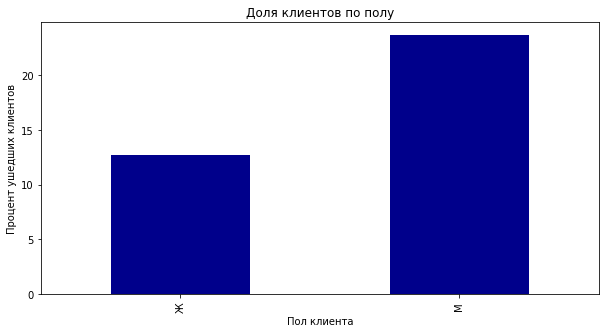

In [53]:
gender_churn = df.pivot_table (index = 'gender', values = 'churn', aggfunc = ['sum', 'count'])
gender_churn.columns = gender_churn.columns.droplevel(level=1)
gender_churn ['procent'] = gender_churn['sum']/gender_churn['count']*100

gender_churn['procent'].plot(
    kind='bar', title = 'Доля клиентов по полу', figsize = (10,5), color = 'darkblue', 
    xlabel = 'Пол клиента', ylabel = 'Процент ушедших клиентов')
plt.show()

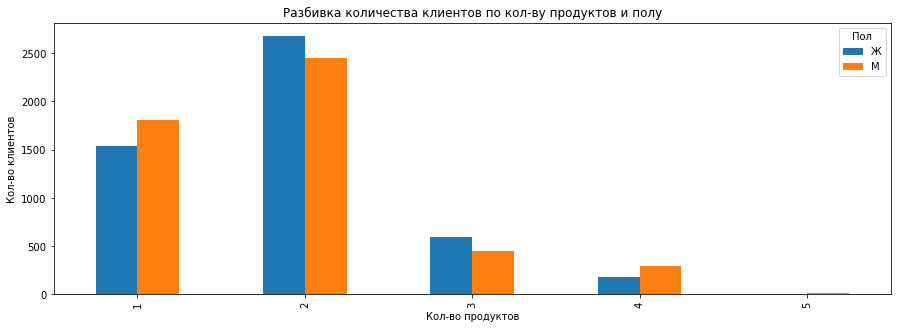

In [54]:
df.pivot_table (columns = 'gender', index = 'products', 
                values = 'user_id', aggfunc = 'count').plot(kind='bar', 
                                                                     figsize=(15,5))

plt.title('Разбивка количества клиентов по кол-ву продуктов и полу')
plt.xlabel('Кол-во продуктов')
plt.ylabel('Кол-во клиентов')
plt.legend(title='Пол')
plt.show()

Женщины потребляют по 1-2 продукта, как и мужчины. Чаще уходят мужчины. Параметр не показательный.

Рассмотрим город.

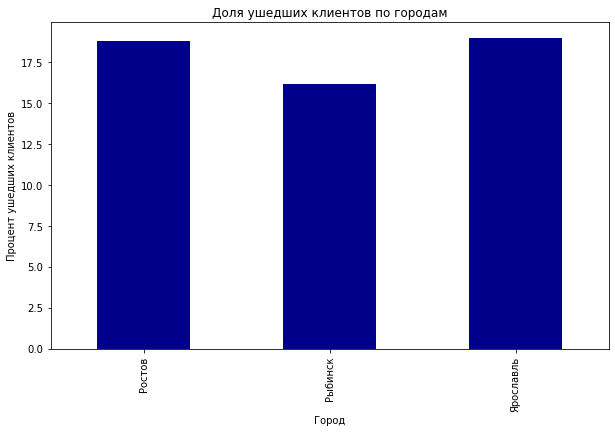

In [55]:
city_churn = df.pivot_table (index = 'city', values = 'churn', aggfunc =['sum', 'count'])
city_churn.columns = city_churn.columns.droplevel(level=1)
city_churn ['procent'] = city_churn['sum']/city_churn['count']*100

city_churn['procent'].plot (
    kind='bar', title = 'Доля ушедших клиентов по городам',
    xlabel = 'Город', ylabel = 'Процент ушедших клиентов', figsize = (10,6), 
    color = 'darkblue')
plt.show()

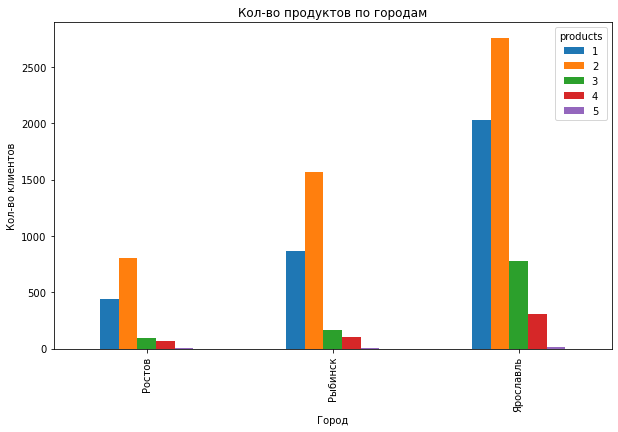

In [56]:
city_churn = df.pivot_table (index = 'city', columns = 'products', values ='user_id', aggfunc= 'count')
city_churn.plot(kind='bar', title = 'Кол-во продуктов по городам',
    xlabel = 'Город', ylabel = 'Кол-во клиентов', figsize = (10,6))
plt.show()

Таким образом, ушедшие клиенты равномерно уходят из всех городов, как и пользуются продуктами. 

### Сегментация
Составим описание сегментов на основании проведенных исследований выше.

Самые влияющие признаки на **кол-во продуктов и отток**:
1. Баллы недвижимости
2. Пол
3. Скоринг
4. Кредитная карта

**Сегмент 1.** Мужчины от 46 до 62, число продуктов: 3+, с баллами собственности 5+, скорингом 900 и больше, без кредитной карты

**Сегмент 2.** Женщины от 46 до 62, число продуктов 3+, с баллами собственности 5+, скорингом 900 и больше, без кредитной карты

По сути сегмент 1 и 2 различаются только по полу, но пол играет важную роль в уходе клиента. 


**Сегмент 3.** Клиенты от 25 до 45, число продуктов 2, баллов собственности 5+, скорингом 750+, **без** кредитной карты

**Сегмент 4.** Мужчины от 25 до 45, число продуктов 3+, баллов собственности 5+, скорингом 900+, кредитная карта **есть**

**Сегмент 5.** Женщины от 25 до 45, число продуктов 3+, баллов собственности 4+, скорингом 750+, кредитная карта **есть**


**Сегмент 6.** Клиенты от 46 до 62, число продуктов 2, с баллами собственности менее 5, скорингом 750+, кредитной карты **нет**

**Сегмент 7.** Клиенты от 46 до 62, число продуктов 1, баллов собствеености меньше 5, скорингом 750+, кредитная карта **есть**

**Сегмент 8.** Клиенты от 63+, число продуктов 1+, баллами собственности 3+, скорингом 770+, кредитная карта **есть**




## Статистическая проверка гипотез

    4.1 Проверка гипотезы о различии возраста клиентов с 1 и 2 продуктами
    4.2 Проверка гипотезы о различии дохода клиентов с 1-2 и 3-5 продуктами
    4.3 Проверка гипотезы о количестве продуктов и статусе ушедшего

### Проверка гипотезы о различии возраста клиентов

Гипотеза о различии возраста между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним.

Сформулируем нулевую и альтернативную гипотезы:

**H₀:** Средний возраст клиентов с 1 продуктом и с 2 продуктами **равны** <br>
**H₁:** Средний возраст клиентов с 1 продуктом и с 2 продуктами **не равны**

Для проверки гипотез проведем **t-test**. Для этого необходимо удалить из датасета строки, где пропущено значение возраста.

In [57]:
df=df[df['age'] != ""]

results = st.ttest_ind (
    df[df['products']==1]['age'],
    df[df['products']==2]['age'], equal_var = False)

alpha = 0.05

# вывод значения p-value на экран 
print (results.pvalue) 
# условный оператор с выводом строки с ответом

if results.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

0.032990807042327125
Отвергаем нулевую гипотезу


Проведенный t-test показал, что нулевую гипотезу об отсутствии различий среднего возраста клиентов с 1 и 2 продуктами опровергнуть не удалось.

### Проверка гипотезы о различии дохода клиентов с 1-2 продуктами и 3-5 продуктами.

Сформулируем нулевую и альтернативную гипотезы:

**H₀:** Средняя заработная плата клиентов с 1-2 продуктом и с 3-5 продуктами **равны** <br>
**H₁:** Средняя заработная плата клиентов с 1-2 продуктом и с 3-5 продуктами **не равны**

Также проведем **t-test**

In [58]:
results = st.ttest_ind (
    df[(df['products']==1) | (df['products']==2)]['salary'],
    df[(df['products']==3) 
       | (df['products']==4) 
       | (df['products']==5)]['salary'], equal_var = False)

alpha = 0.05

# вывод значения p-value на экран 
print (results.pvalue) 
# условный оператор с выводом строки с ответом

if results.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

9.53057839490827e-06
Отвергаем нулевую гипотезу


Таким образом, мы не можем принять нулевую гипотезу и утверждать, что заработная плата клиентов с 1-2 и 3-5 продуктами равна.

### Гипотеза о различии количества продуктов и статуса ушедшего.

Сформулируем нулевую и альтернативную гипотезы:

**H₀:** Среднее количество продуктов оставшихся и ушедших клиентов **равны** <br>
**H₁:** Среднее количество продуктов оставшихся и ушедших клиентов **не равны**

Также проведем **t-test**

In [59]:
results = st.ttest_ind (
    df[df['churn']==0]['products'],
    df[df['churn']==1]['products'], equal_var = False)

alpha = 0.05

# вывод значения p-value на экран 
print (results.pvalue) 
# условный оператор с выводом строки с ответом

if results.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

1.2671065900765871e-138
Отвергаем нулевую гипотезу


Мы не можем принять нулевую гипотезу о равенстве количества продуктов ушедших и оставшихся клиентов.

## Рекомендации по удержанию клиентов 
(описание сегмента+конкретная рекомендация)


Самые влияющие признаки на кол-во продуктов и отток:
1. Пол
2. Баллы собственности
3. Скоринг
4. Кредитная карта
5. Активность

После проведенного исследования были выявлены 8 сегментов:

**Сегмент 1.** Мужчины от 46 до 62, число продуктов: 3+, с баллами собственности 5+, скорингом 900 и больше, без кредитной карты

**Сегмент 2.** Женщины от 46 до 62, число продуктов 3+, с баллами собственности 5+, скорингом 900 и больше, без кредитной карты

По сути сегмент 1 и 2 различаются только по полу, но пол играет важную роль в уходе клиента. 


**Сегмент 3.** Клиенты от 25 до 45, число продуктов 2, баллов собственности 5+, скорингом 750+, **без** кредитной карты

**Сегмент 4.** Мужчины от 25 до 45, число продуктов 3+, баллов собственности 5+, скорингом 900+, кредитная карта **есть**

**Сегмент 5.** Женщины от 25 до 45, число продуктов 3+, баллов собственности 4+, скорингом 750+, кредитная карта **есть**


**Сегмент 6.** Клиенты от 46 до 62, число продуктов 2, с баллами собственности менее 5, скорингом 750+, кредитной карты **нет**

**Сегмент 7.** Клиенты от 46 до 62, число продуктов 1, баллов собствеености меньше 5, скорингом 750+, кредитная карта **есть**

**Сегмент 8.** Клиенты от 63+, число продуктов 1+, баллами собственности 3+, скорингом 770+, кредитная карта **есть**


Для каждого сегмента необходимо дать рекомендации по предложению им релевантных продуктов:

**Сегмент 1:** 
+ обеспечить условия для страхования недвижимости
+ **льготные условия для оформления кредитной карты**
+ предложить кэшбэк на товары для мужчин

**Сегмент 2:** 
+ **льготные условия для оформления кредитной карты**
+ предложить страхование недвижимости
+ предложить кэшбэк на товары для женщин
    
**Сегмент 3:** 
+ **предложить оформление кредитной карты**
+ **предложить страхование недвижимости**
+ сделать упор на количество продуктов банка для удержания клиента в банке
    
**Сегмент 4:** 
+ **предложить страхование недвижимости**
+ **предложить оформление кредитной карты**
+ предложить страхование недвижимости
+ предложить кэшбэк на товары для женщин
    
**Сегмент 5:** 
+ **предложить оформление кредитной карты**
+ увеличить информирование о новых продуктах
+ льготные условия для перевода заработной платы в банк

**Сегмент 6:** 
+ **предложить оформление кредитной карты**
+ увеличить информирование о новых продуктах
+ повышенный кэшбэк на товары для мужчин
    
**Сегмент 7:** 
+ увеличить информирование о новых продуктах
+ льготные условия для перевода заработной платы в банк
    
**Сегмент 8:** 
+ увеличить информирование о новых продуктах
+ льготные условия для перевода пенсии в банк


## Презентация

https://disk.yandex.ru/i/VjZbQKeBckPU9w

# Дашборд

https://public.tableau.com/app/profile/daria5926/viz/Banks_16809423475810/Dashboard1